# W1 Review Code

## 1. Import packages

In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

#import util

## 2. Checking Data Leakage
* Write a function to check whether there is leakage between two datasets.
* We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

###  2.1 Identifying Overlapping Records
Function: **check_for_leakage**: Return True if there any patients are in both df1 and df2

    """
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs

    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """


In [36]:
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) != 0 # boolean (true if there is at least 1 patient in both groups)

    return leakage

If we get False for both, then we're ready to start preparing the datasets for training. Remember to always check for data leakage!

In [223]:
def zach_check_for_leakage(df1, df2, input_col):
    df1_patients_unique = set(df1[input_col].values)
    df2_patients_unique = set(df2[input_col].values)

    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) != 0 # boolean (true if there is at least 1 patient in both groups)

    if leakage is False:
        return print(f'Leakage: {leakage}.There is No Leakage between the datasets. Ready to start preparing the datasets for training')
    else:
        return print(f'Leakage: {leakage}. There are {len(patients_in_both_groups)} records in both the datasets: {patients_in_both_groups}')

Run the next cell to check if there are patients in both train and test or in both valid and test.

In [224]:
#Case 1
case1_train_df = pd.DataFrame({'PatientId': [0, 1, 2,3,4,5,6,8]})
case1_valid_df= pd.DataFrame({'PatientId': [9, 10, 11,12]})
case1_test_df = pd.DataFrame({'PatientId': [6, 0, 4,21,22,23,35]})
zach_check_for_leakage(case1_train_df, case1_test_df, 'PatientId')
zach_check_for_leakage(case1_valid_df, case1_test_df, 'PatientId')

### 2.2 Check & Remove Overlapping Records
* Write a function `remove_overlapping_records` to check and remove overlapping records if existed between two datasets.
    * Removed record from the second set: `df2.drop(df2_overlap_idxs, inplace=True`
* We'll use this to make sure there are no record in the second set that are also present in the first set.

    """
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        input_col (str): string name of column need for checking overlapping records.

    Returns:
       ...
    """

In [209]:
def remove_overlapping_records (df1, df2, input_col):
    ids_df1 = df1[input_col].values
    ids_df2 = df2[input_col].values

    df2_original_len=len(df2)

    ids_df1_set = set(ids_df1)
    ids_df2_set = set(ids_df2)

    records_overlap=  list(ids_df1_set.intersection(ids_df2_set))
    n_overlap = len(records_overlap)

    df1_overlap_idxs = []
    df2_overlap_idxs = []

    for idx in range(n_overlap):
        df1_overlap_idxs.extend(df1.index[df1[input_col] == records_overlap[idx]].tolist())
        df2_overlap_idxs.extend(df2.index[df2[input_col] == records_overlap[idx]].tolist())

    leakage = n_overlap != 0 # boolean (true if there is at least 1 patient in both groups)

    if leakage is False:
        return print(f'{leakage}: There is No Leakage between the datasets. Ready to start preparing the datasets for training')
    else:
        return \
            print(
                f'Leakage: {leakage}. There are {n_overlap} records in both the datasets: {records_overlap}'), print(
                f'First datase - indices of overlapping records:{df1_overlap_idxs}'), print(
                f'Second datase - indices of overlapping records:{df2_overlap_idxs}'), df2.drop(df2_overlap_idxs, inplace=True), print(
                f'Removed {len(df2_overlap_idxs)} overlapping record from the second dataframe.'), print(
                f'Original lenght of the second dataframe: {df2_original_len}'), print(
                f'New lenght of the second dataframe: {len(df2)}')

In [226]:
#Case 1
case1_train_df = pd.DataFrame({'PatientId': [0, 1, 2,3,4,5,6,8]})
case1_valid_df= pd.DataFrame({'PatientId': [9, 10, 11,12]})
case1_test_df = pd.DataFrame({'PatientId': [6, 0, 4,21,22,4,0,23,35]})

In [227]:
remove_overlapping_records(case1_train_df, case1_test_df, 'PatientId')

Leakage: True. There are 3 records in both the datasets: [0, 4, 6]
First datase - indices of overlapping records:[0, 4, 6]
Second datase - indices of overlapping records:[1, 6, 2, 5, 0]
Removed 5 overlapping record from the second dataframe.
Original lenght of the second dataframe: 9
New lenght of the second dataframe: 4


(None, None, None, None, None, None, None)

In [228]:
zach_check_for_leakage(case1_valid_df, case1_test_df, 'PatientId')

Leakage: False.There is No Leakage between the datasets. Ready to start preparing the datasets for training


In [229]:
# Read csv file containing training data
train_df = pd.read_csv("data/nih/train-small.csv")
# Print first 5 rows
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the training dataframe')
train_df.head()

There are 1000 rows and 16 columns in the training dataframe


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [230]:
# Read csv file containing validation data
valid_df = pd.read_csv("data/nih/valid-small.csv")
# Print first 5 rows
print(f'There are {valid_df.shape[0]} rows and {valid_df.shape[1]} columns in the validation dataframe')
valid_df.head()

There are 109 rows and 16 columns in the validation dataframe


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027623_007.png,0,0,0,1,1,0,0,0,0,0,0,27623,0,0,0
1,00028214_000.png,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0
2,00022764_014.png,0,0,0,0,0,0,0,0,0,0,0,22764,0,0,0
3,00020649_001.png,1,0,0,0,1,0,0,0,0,0,0,20649,0,0,0
4,00022283_023.png,0,0,0,0,0,0,0,0,0,0,0,22283,0,0,0


In [292]:
test_df = pd.read_csv("nih/test.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'nih/test.csv'

In [231]:
zach_check_for_leakage(train_df,valid_df,'PatientId')

Leakage: True. There are 11 records in both the datasets: {20290, 27618, 9925, 10888, 22764, 19981, 18253, 4461, 28208, 8760, 7482}


In [232]:
remove_overlapping_records(train_df,valid_df,'PatientId')

Leakage: True. There are 11 records in both the datasets: [20290, 27618, 9925, 10888, 22764, 19981, 18253, 4461, 28208, 8760, 7482]
First datase - indices of overlapping records:[306, 186, 797, 98, 408, 917, 327, 913, 10, 51, 276]
Second datase - indices of overlapping records:[104, 88, 65, 13, 2, 41, 56, 70, 26, 75, 20, 52, 55]
Removed 13 overlapping record from the second dataframe.
Original lenght of the second dataframe: 109
New lenght of the second dataframe: 96


(None, None, None, None, None, None, None)

In [243]:
len(train_df.columns)

16

In [234]:
valid_df.shape

(96, 16)

## 3. Preparing Images
### 3.1 Generator for training set
1. Normalize the mean and standard deviation of the data
2. Shuffle the input after each epoch.
3. Set the image size to be 320px by 320px

"""
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """

In [294]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

### 3.2 Generator for testing & validating dataset
**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data.

* It normalizes each image per batch, meaning that it uses batch statistics.
* We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
* Knowing the average per batch of test data would effectively give our model an advantage.
    * The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics computed from the training set.
* We implement this in the function below.
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set.
* However, since this is extremely large, that would be very time consuming.
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.




    """
    Return generator for validation set and test test set using
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.

    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """

In [246]:
IMAGE_DIR = "nih/images-small/"

#### 3.2.1 Remove a list of values from another list
* Function `remove_list_from_list`

In [282]:
def remove_list_from_list(original_list,remove_columns_list):
    for item in original_list:
        if item in remove_columns_list:
            original_list.remove(item)
    return original_list

In [283]:
list(train_df.columns)

['Image',
 'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'PatientId',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [284]:
remove_columns_list = ['Image','PatientId']
remove_columns_list

['Image', 'PatientId']

In [290]:
labels=remove_list_from_list(list(train_df.columns),remove_columns_list)
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [301]:
IMAGE_DIR = "data/nih/images-small"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
#valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


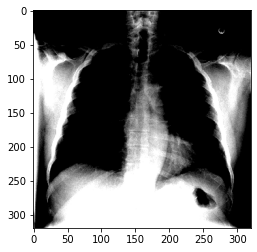

In [302]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

## 4. Model Development
Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.